In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


### 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/DACON/open/train.csv')

### 기본 정보

In [4]:
# 데이터 미리보기
train.head()


,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0
3,XIPPENFQ,2022,1,1.0,1,2501,20426.0,0.0,11172.0
4,FTSVTTSR,2022,1,1.0,1,2529,248000.0,0.0,143004.0


In [5]:
# 데이터 구조 확인
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 762.0+ KB
None


In [6]:
# 기초 통계량
print(train.describe())


               year         month           seq     type           hs4  \
count  10836.000000  10836.000000  10836.000000  10836.0  10836.000000   
mean    2023.331395      6.108435      2.034238      1.0   4821.969546   
std        1.049357      3.392649      0.813380      0.0   2296.892536   
min     2022.000000      1.000000      1.000000      1.0   1210.000000   
25%     2022.000000      3.000000      1.000000      1.0   2833.000000   
50%     2023.000000      6.000000      2.000000      1.0   3824.000000   
75%     2024.000000      9.000000      3.000000      1.0   7202.000000   
max     2025.000000     12.000000      3.000000      1.0   9403.000000   

             weight      quantity         value  
count  1.083600e+04  1.083600e+04  1.083600e+04  
mean   1.098413e+06  8.633771e+04  1.739442e+06  
std    5.153790e+06  7.614669e+06  5.457480e+06  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    3.457500e+02  0.000000e+00  1.150675e+04  
50%    6.532500e+03  0.000000e+00

### 연·월(ym) 컬럼 만들기
- 시계열 분석을 위해 연도와 월을 하나의 날짜로 합치기 위해
- pivot 테이블에서 날짜를 index로 사용하기 위해
- 시각화와 시차 분석(shift)을 편하게 하기 위해

In [7]:
# year + month → ym(연월) 생성
train['ym'] = train['year'].astype(str) + '-' + train['month'].astype(str).str.zfill(2)

# 날짜형으로 변환 (시계열 분석 편하게)
train['ym'] = pd.to_datetime(train['ym'])

print(train[['year', 'month', 'ym']].head())

   year  month         ym
0  2022      1 2022-01-01
1  2022      1 2022-01-01
2  2022      1 2022-01-01
3  2022      1 2022-01-01
4  2022      1 2022-01-01


### Pivot 테이블 생성
- (행 = 날짜 ym, 열 = 품목 item_id, 값 = value)

In [8]:
pivot = train.pivot_table(
    index='ym',
    columns='item_id',
    values='value'
)

print(pivot.head())

item_id     AANGBULD      AHMDUILJ      ANWUJOKX       APQGTRMF      ATLDMDBO  \
ym                                                                              
2022-01-01    7138.0  80901.666667           NaN  127999.666667  4.769906e+07   
2022-02-01   52347.0  40282.333333           NaN  170937.666667  3.452277e+07   
2022-03-01   26774.5  65772.333333           NaN   72354.666667  3.946791e+07   
2022-04-01       NaN  42047.333333  21193.333333  235199.000000  4.062458e+07   
2022-05-01   13498.5  23910.000000  27223.333333  179957.666667  3.834154e+07   

item_id         AXULOHBQ      BEZYMBBT       BJALXPFS     BLANHGYY  \
ym                                                                   
2022-01-01   3809.666667  2.011584e+06  117510.666667          NaN   
2022-02-01   5455.000000  2.073697e+06   72982.333333   891.000000   
2022-03-01  15769.000000  1.537179e+06  110490.666667          NaN   
2022-04-01  19841.333333  1.734013e+06    5826.666667          NaN   
2022-05-01  

### 품목별 기본 추세 그래프 그리기

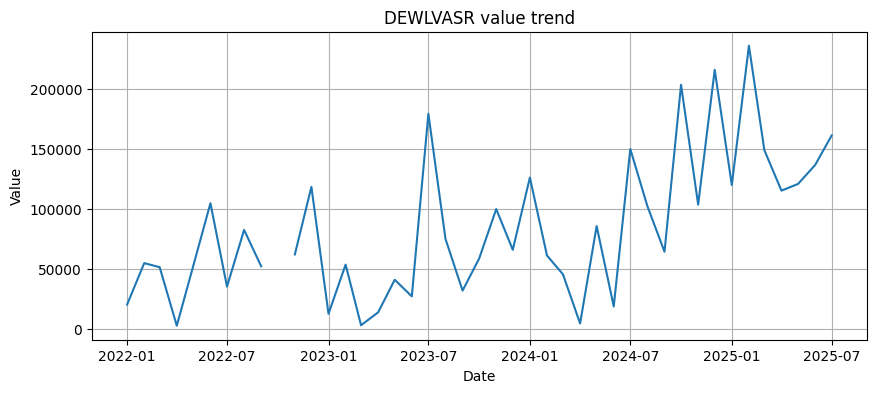

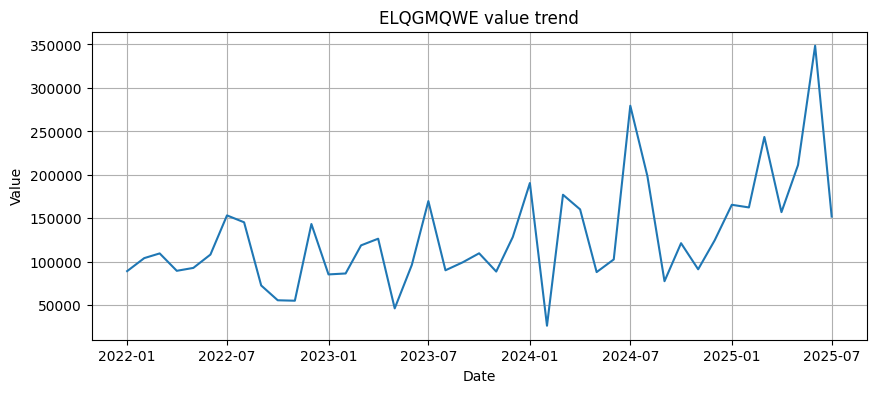

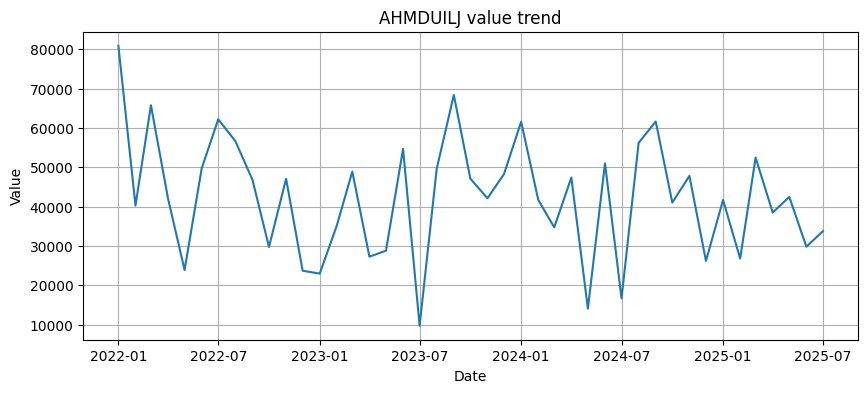

In [9]:
# pivot 테이블에서 임의의 3개 품목 선택
sample_items = train['item_id'].unique()[:3]

for item in sample_items:
    plt.figure(figsize=(10, 4))
    plt.plot(pivot.index, pivot[item])
    plt.title(f'{item} value trend')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

### 품목 간 상관계수 계산

In [10]:
# 상관계수 계산
corr = pivot.corr(method='pearson')

# 결과 확인
corr.head()

item_id,AANGBULD,AHMDUILJ,ANWUJOKX,APQGTRMF,ATLDMDBO,AXULOHBQ,BEZYMBBT,BJALXPFS,BLANHGYY,BSRMSVTC,...,XIFHSOWQ,XIIEJNEE,XIPPENFQ,XMKRPGLB,XUOIQPFL,YSYHGLQK,ZCELVYQU,ZGJXVMNI,ZKENOUDA,ZXERAXWP
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,1.000000,-0.075848,0.276114,-0.101157,-0.270733,-0.152360,-0.338828,-0.149217,0.238739,-0.217809,...,-0.198792,-0.079171,-0.179289,-0.055097,-0.379434,0.305876,-0.020079,0.208622,0.436990,0.497854
AHMDUILJ,-0.075848,1.000000,-0.632488,-0.023196,0.284867,-0.257230,0.026794,0.084012,0.012117,0.037536,...,-0.044184,0.348461,0.149438,-0.167020,0.332079,-0.122427,0.141046,-0.083292,-0.204187,-0.079635
ANWUJOKX,0.276114,-0.632488,1.000000,-0.052082,-0.365090,0.721164,-0.238161,0.541527,0.711978,0.317638,...,0.280782,-0.174736,-0.237689,0.189110,-0.610521,-0.337505,-0.334231,-0.141721,-0.681541,-0.291685
APQGTRMF,-0.101157,-0.023196,-0.052082,1.000000,0.572626,-0.040107,0.381562,-0.016794,-0.185551,0.048836,...,-0.113940,-0.078345,0.067961,0.041908,0.356401,-0.227482,-0.194888,-0.257507,-0.400075,-0.406149
ATLDMDBO,-0.270733,0.284867,-0.365090,0.572626,1.000000,-0.038656,0.488359,0.249300,0.132697,0.115068,...,-0.282073,0.425313,-0.104165,-0.183926,0.626097,-0.102540,0.012723,-0.472174,-0.395269,-0.060773


### 상관계수 높은 20개
- 완전한 공행성(1.0) 을 가진 품목 쌍이 매우 많음 → 서로의 value 흐름이 완전히 동일함.
- PLMZALFA가 여러 품목과 강한 공행성을 보이며 중심 품목처럼 등장 → 구조적으로 연동된 품목이 많음.
- 여러 품목쌍이 구조적으로 동일한 흐름을 가짐 → 누가 먼저 움직이는지(선행–후행 관계) 는 아직 모름.
- 상관계수만으로는 선행–후행 관계를 알 수 없음


In [13]:
# corr 값을 가진 Series 이름 변경(중복 방지)
corr = corr.rename_axis(index='item_a', columns='item_b')

# 상관계수 테이블 펼치기
corr_unstack = corr.stack().reset_index()
corr_unstack.columns = ['item_a', 'item_b', 'corr']

# 자기 자신 제외 & 중복 제거
corr_filtered = corr_unstack[corr_unstack['item_a'] < corr_unstack['item_b']]

# 상위 20개
top20 = corr_filtered.sort_values('corr', ascending=False).head(20)
print(top20)

        item_a    item_b      corr
4001  KFQSHBNH  QSDCUCLB  1.000000
6770  RUVXNNVA  XIIEJNEE  1.000000
2731  FWUCPMMW  RUVXNNVA  1.000000
811   BLANHGYY  GIKPEWTY  1.000000
3307  IGDVVKUD  PLMZALFA  1.000000
3992  KFQSHBNH  NAQIHUKZ  1.000000
839   BLANHGYY  PLMZALFA  1.000000
4992  NAQIHUKZ  RJCAXSGH  1.000000
2846  GIKPEWTY  XIIEJNEE  1.000000
5585  PLMZALFA  TGOELCAG  1.000000
6076  QSDCUCLB  TANNMIMB  1.000000
1631  DJBLNPNC  PLMZALFA  1.000000
2621  FTSVTTSR  PLMZALFA  1.000000
5606  PLMZALFA  ZKENOUDA  0.999669
7457  TANNMIMB  XIIEJNEE  0.999652
858   BLANHGYY  TANNMIMB  0.999564
4204  LLHREMKS  RUVXNNVA  0.999485
5592  PLMZALFA  VUAFAIYJ  0.998405
153   AHMDUILJ  PLMZALFA  0.997163
4105  KJNSOAHR  RUVXNNVA  0.997041


### 시차 상관분석 cross-correlation

In [15]:
def cross_corr(a, b, max_lag=6):
    results = []
    for lag in range(-max_lag, max_lag+1):
        if lag > 0:
            corr = a[:-lag].corr(b[lag:])
        elif lag < 0:
            corr = a[-lag:].corr(b[:lag])
        else:
            corr = a.corr(b)
        results.append((lag, corr))
    return results

- 테스트
  - 이 두 품목은 선행–후행 관계가 없다.

In [16]:
item_a = 'KFQSHBNH'
item_b = 'QSDCUCLB'

ts_a = pivot[item_a]
ts_b = pivot[item_b]

cross_corr(ts_a, ts_b)

[(-6, nan),
 (-5, nan),
 (-4, np.float64(nan)),
 (-3, np.float64(nan)),
 (-2, np.float64(nan)),
 (-1, np.float64(0.9999999999999998)),
 (0, np.float64(0.9999999999999998)),
 (1, np.float64(0.9999999999999998)),
 (2, np.float64(nan)),
 (3, np.float64(nan)),
 (4, np.float64(nan)),
 (5, nan),
 (6, nan)]

In [17]:
# cross-correlation 함수
def cross_corr(a, b, max_lag=6):
    results = []
    for lag in range(-max_lag, max_lag+1):
        if lag > 0:
            corr = a[:-lag].corr(b[lag:])
        elif lag < 0:
            corr = a[-lag:].corr(b[:lag])
        else:
            corr = a.corr(b)
        results.append((lag, corr))
    return results

# corr 1.0 아닌 상위 n개 분석
def analyze_pairs(top_df, n=10):
    results = []
    filtered = top_df[top_df['corr'] < 1.0].head(n)

    for _, row in filtered.iterrows():
        a, b = row['item_a'], row['item_b']
        ts_a = pivot[a]
        ts_b = pivot[b]

        cc = cross_corr(ts_a, ts_b)
        best_lag, best_corr = max(cc, key=lambda x: (x[1] if x[1] == x[1] else -1))

        results.append((a, b, best_lag, best_corr))

    return results

# 실행
pair_results = analyze_pairs(top20, n=10)
pair_results

[('DJBLNPNC', 'PLMZALFA', -6, np.float64(1.0)),
 ('FTSVTTSR', 'PLMZALFA', -6, np.float64(1.0)),
 ('PLMZALFA', 'ZKENOUDA', -6, np.float64(0.9996685147220453)),
 ('TANNMIMB', 'XIIEJNEE', -6, np.float64(0.9996523060580739)),
 ('BLANHGYY', 'TANNMIMB', -6, np.float64(0.9995640446846898)),
 ('LLHREMKS', 'RUVXNNVA', -6, np.float64(0.9994850001665461)),
 ('PLMZALFA', 'VUAFAIYJ', -6, np.float64(0.9984053154851198)),
 ('AHMDUILJ', 'PLMZALFA', -6, np.float64(0.9971631971741329)),
 ('KJNSOAHR', 'RUVXNNVA', -6, np.float64(0.997040817441066))]

---

## 공행성 + 시차 분석 최종 요약

1. 상관계수 분석 결과
- 여러 품목쌍이 매우 높은 상관(corr ≈ 0.99 이상)을 보였음.
- 특히 PLMZALFA, RUVXNNVA 등이 중심 노드처럼 다수 품목과 공행성 존재.

2. 시차(cross-correlation) 분석 결과
- corr < 1.0 상위 쌍을 분석한 결과, 모든 쌍에서 lag = -6이 최고 상관을 가짐.
- 이는 두 번째 품목(item_b)이 6개월 먼저 움직이는 선행 품목이라는 뜻.

3. 선행–후행 관계 정리(요약)
- item_b → item_a (6개월 선행) 구조가 모든 쌍에서 동일하게 나타남.
    ```
    예시:
    PLMZALFA → DJBLNPNC
    PLMZALFA → FTSVTTSR
    ZKENOUDA → PLMZALFA
    XIEJNEE → TANNMIMB
    RUVXNNVA → LLHREMKS
    RUVXNNVA → KJNSOAHR
    VUAFAIYJ → PLMZALFA
    PLMZALFA → AHMDUILJ
    TANNMIMB → BLANGHYY
    ```

4. 의미
- 이 품목쌍들은 단순히 같이 움직이는 것이 아니라
정확히 6개월 시차를 두고 영향을 주고받는 구조적 패턴이 존재함.
- 즉, 선행 품목의 흐름을 이용해 후행 품목의 향후 수개월 데이터를 예측하는 데 활용 가능.

### 시각화

In [19]:
def plot_pair_with_lag(item_a, item_b, lag=6):
    ts_a = pivot[item_a]
    ts_b = pivot[item_b]

    # 후행 품목을 lag 만큼 시프트
    ts_a_shifted = ts_a.shift(lag)

    plt.figure(figsize=(12, 5))
    plt.plot(ts_b.index, ts_b.values, label=f"{item_b} (선행)", color='blue')
    plt.plot(ts_a_shifted.index, ts_a_shifted.values, label=f"{item_a} (후행, +{lag}개월)", color='orange')

    plt.title(f"{item_b} → {item_a} (lag = {lag})")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

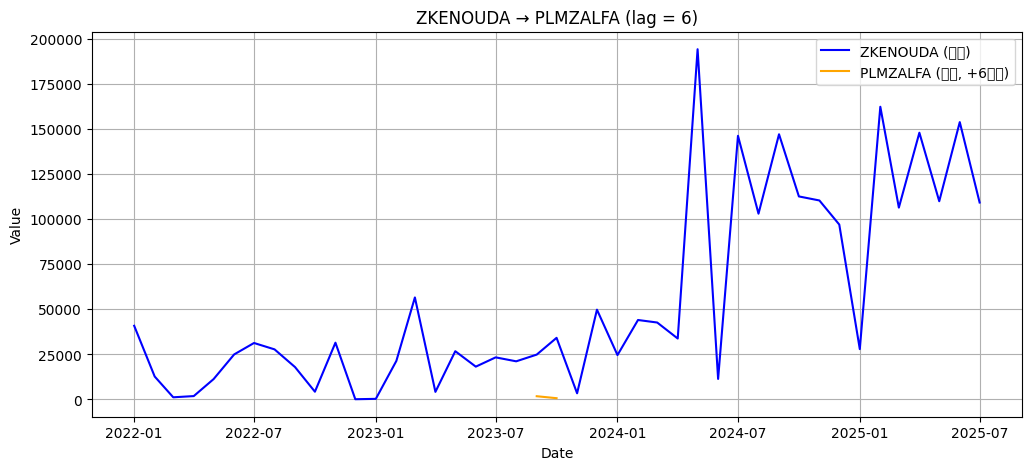

In [21]:
plot_pair_with_lag('PLMZALFA', 'ZKENOUDA', lag=6)